<a href="https://colab.research.google.com/github/KaeganCasey/digital_advertising_analytics-/blob/master/Google_Twitter_Poll_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='nav'></a>
# Navigation
Introduction/Poll Data:
1.   [Import Libraries and Mount Drive](#lib)
2.   [Poll Data Descripive Stats](#desc)

Social Studio Data:
3.   [Joining Together Social Studio Data](#socialjoin)
4.   [Social Studio Data](#social_data) 

Google Trends Data:
5.   [Aquire Google Search Data Using Pytrends API](#pytrends)
6.   [Concatinating Google Data Together](#concatpy)

Merging Data:
7.   [Combining Social Studio and Google Data](#google_social)
8.   [Merging Poll Data with Social Studio and Google Trends Data](#add_poll)

Linear Models:
9.   [Inspecting and Preparing Data](#inspect)
10.  [Base Model With Social Studio and Twitter Data](#model_both)
11.  [Linear Model Predicting % Change in Poll Numbers](#percent_change)
12.  [Linear Model Removing Debate Days Predicting % Change](#debate_days)

Autoregressive Models:
13.  [Checking for Autocorrelation and Stationality Among Dependant Variable](#auto)
14.  [Prophet Models](#prophet)
15.  [ARIMA Models](#arima)



# **INTRODUCTION:**

<a name='lib'></a>



---




[Back to Navigation](#nav)

# Import Libraries and Mount Drive


In [1]:
!pip install pytrends
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


from pytrends.request import TrendReq
from google.colab import drive


from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

drive.mount('/content/drive')

  Created wheel for pytrends: filename=pytrends-4.7.2-cp36-none-any.whl size=14260 sha256=4da4d75571f34e1c2886068ac5b66109ef06909fe73428eedff58c9fb52f38b8
  Stored in directory: /root/.cache/pip/wheels/64/ae/af/51d48fbbca0563036c6f80999b7ce3f097fa591fd165047baf
Successfully built pytrends
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<a name='desc'></a>



---




[Back to Navigation](#nav)

# Poll Data Descriptive Statistics
Aquired from [FiveThirtyEight](#https://data.fivethirtyeight.com/)

### Import data

In [2]:
file = 'drive/My Drive/Colab Notebooks/project/president_primary_polls.csv'
polls = pd.read_csv(file)
polls.head()

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,pollster_rating_name,fte_grade,sample_size,population,population_full,methodology,office_type,start_date,end_date,sponsor_candidate,internal,partisan,tracking,nationwide_batch,created_at,notes,url,stage,party,answer,candidate_id,candidate_name,pct
0,113430,62715,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,88.0,Emerson College,A-,426,lv,lv-r,IVR/Online,U.S. President,11/17/19,11/20/19,NaN,False,NaN,False,False,11/21/19 12:02,NaN,http://emersonpolling.com/2019/11/21/november-...,primary,REP,Trump,13254,Donald Trump,93.2
1,113430,62715,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,88.0,Emerson College,A-,426,lv,lv-r,IVR/Online,U.S. President,11/17/19,11/20/19,NaN,False,NaN,False,False,11/21/19 12:02,NaN,http://emersonpolling.com/2019/11/21/november-...,primary,REP,Weld,13351,William F. Weld,2.7
2,113430,62715,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,88.0,Emerson College,A-,426,lv,lv-r,IVR/Online,U.S. President,11/17/19,11/20/19,NaN,False,NaN,False,False,11/21/19 12:02,NaN,http://emersonpolling.com/2019/11/21/november-...,primary,REP,Walsh,13482,Joe Walsh,4.1
3,113431,62715,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,88.0,Emerson College,A-,468,lv,lv-d,IVR/Online,U.S. President,11/17/19,11/20/19,NaN,False,NaN,False,False,11/21/19 12:02,NaN,http://emersonpolling.com/2019/11/21/november-...,primary,DEM,Booker,13287,Cory A. Booker,0.7
4,113431,62715,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,88.0,Emerson College,A-,468,lv,lv-d,IVR/Online,U.S. President,11/17/19,11/20/19,NaN,False,NaN,False,False,11/21/19 12:02,NaN,http://emersonpolling.com/2019/11/21/november-...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,27.4


In [3]:
polls.shape

(13588, 33)

In [0]:
# polls.dtypes # long output

In [5]:
polls.describe()

,question_id,poll_id,cycle,pollster_id,pollster_rating_id,sample_size,sponsor_candidate,candidate_id,pct
count,13588.000000,13588.000000,13588.0,13588.000000,13266.000000,13588.000000,0.0,13588.000000,13588.000000
mean,100755.630336,59244.396747,2020.0,1020.093023,212.488994,1697.922947,NaN,13312.297395,5.899324
std,5712.499365,1460.018172,0.0,435.788343,126.747491,3533.746061,NaN,36.202414,11.623467
min,92381.000000,56853.000000,2020.0,4.000000,3.000000,14.000000,NaN,13253.000000,0.000000
25%,94761.000000,58190.000000,2020.0,568.000000,133.000000,444.000000,NaN,13287.000000,0.000000
50%,100322.000000,58834.000000,2020.0,1189.000000,154.000000,626.000000,NaN,13316.000000,1.000000
75%,103086.000000,59640.000000,2020.0,1416.000000,314.000000,1204.000000,NaN,13343.000000,5.000000
max,113431.000000,62715.000000,2020.0,1522.000000,523.000000,17824.000000,NaN,13482.000000,95.000000


In [6]:
## CHECK THE NULL OF EACH COLUMNS
# the commented code gives you the number of null values for each column, 
# the uncommented code gives you the % of null values
# polls.isnull().sum(axis=0) 
polls.isnull().sum(axis=0) / polls.shape[0]

question_id             0.000000
poll_id                 0.000000
cycle                   0.000000
state                   0.643288
pollster_id             0.000000
pollster                0.000000
sponsor_ids             0.445540
sponsors                0.445540
display_name            0.000000
pollster_rating_id      0.023697
pollster_rating_name    0.023697
fte_grade               0.080144
sample_size             0.000000
population              0.000000
population_full         0.000000
methodology             0.002723
office_type             0.000000
start_date              0.000000
end_date                0.000000
sponsor_candidate       1.000000
internal                0.000000
partisan                0.994039
tracking                0.000000
nationwide_batch        0.000000
created_at              0.000000
notes                   0.845673
url                     0.000000
stage                   0.000000
party                   0.000000
answer                  0.000000
candidate_

### Reduce number of columns to allow for easier handling

In [7]:
#SELECT IMPORTANT COLUMNS
cols = ['pollster', 'fte_grade', 'sample_size', 'start_date', 'end_date', 'party', 'answer', 'candidate_id', 'pct']
subpolls = polls[cols]
subpolls.head()

,pollster,fte_grade,sample_size,start_date,end_date,party,answer,candidate_id,pct
0,Emerson College,A-,426,11/17/19,11/20/19,REP,Trump,13254,93.2
1,Emerson College,A-,426,11/17/19,11/20/19,REP,Weld,13351,2.7
2,Emerson College,A-,426,11/17/19,11/20/19,REP,Walsh,13482,4.1
3,Emerson College,A-,468,11/17/19,11/20/19,DEM,Booker,13287,0.7
4,Emerson College,A-,468,11/17/19,11/20/19,DEM,Biden,13256,27.4


In [8]:
##Removed polls with a rating of D or F  (BAD POLLS: banned FROM FIVE_THIRTYEIGHT)
# subset out polls with a D- rating, probably unreliable
# an F rating means fivethirtyeight has banned a poll 
# organization and D- seems suspiciously close.
before = subpolls.shape[0]

subpolls = subpolls.loc[subpolls['fte_grade'] != 'D-']

after = subpolls.shape[0]
before - after    # lost 120 rows, approx 7 or 8 days of data with 16 candidates being recorded


120

### Some polls ended on the same day so these had to be aggregated using their mean 

In [9]:
gbpolls = subpolls.groupby(['end_date', 'answer'], as_index=False)['pct'].mean()
gbpolls.head()

,end_date,answer,pct
0,1/13/19,Biden,31.0
1,1/13/19,Bloomberg,4.0
2,1/13/19,Booker,3.0
3,1/13/19,Brown,1.0
4,1/13/19,Bullock,1.0


In [0]:
### This is for checking our date range, long output
# subpolls['end_date'].unique()

### Convert end_date to datetime

In [11]:
#change time 
gbpolls['end_date'] = pd.to_datetime(gbpolls['end_date'], format="%m/%d/%y")
gbpolls.dtypes

end_date    datetime64[ns]
answer              object
pct                float64
dtype: object

In [12]:
gbpolls.head()

,end_date,answer,pct
0,2019-01-13,Biden,31.0
1,2019-01-13,Bloomberg,4.0
2,2019-01-13,Booker,3.0
3,2019-01-13,Brown,1.0
4,2019-01-13,Bullock,1.0


# **SOCIAL STUDIO DATA:**

<a name='socialjoin'></a>



---




[Back to Navigation](#nav)

# Joining Together Social Studio Data

There are 4 .csv files for each candidate which represent the 4, 30 day periods that were sampled from social studio. These were named similar to "bernie1.csv"-"bernie4.csv" for each candidate respectively. The code below was run once to combine and export these files into aggregate ones for each candidate that looked like "bernie.csv", "biden.csv" etc.

In [0]:
from google.colab import files


# fpstart = 'drive/My Drive/Colab Notebooks/project/social_data/raw/'
# csv = '.csv'
# count = 1

# for cand in candidates:
#   name = cand

#   file1 = fpstart + name + str(count) + csv
#   data1 = pd.read_csv(file1)

#   file2 = fpstart + name + str(count+1) + csv
#   data2 = pd.read_csv(file2)

#   file3 = fpstart + name + str(count+2) + csv
#   data3 = pd.read_csv(file3)

#   file4 = fpstart + name + str(count+3) + csv
#   data4 = pd.read_csv(file4)

#   datafull = pd.concat([data1, data2, data3, data4])
#   datafull.to_csv(name+csv)
  

Those aggregate files created above are now combined into a full dataset that contains all of the social studio data with a column designated "candidate" for which candidate the data corresponds to. This dataframe was also exported so it can be read in every time and avoid having to run these 2 cells.

In [0]:
# fpstart = 'drive/My Drive/Colab Notebooks/project/social_data/candidate/'
# csv = '.csv'

# candidates = ['bernie', 'biden', 'booker', 'buttigieg', 'gabbard', 'harris', 'klobuchar', 'steyer', 'warren', 'yang']
# #bern = pd.read_csv(fpstart, index_col=0)
# full = pd.DataFrame(columns=['segments__series', 'datetime', 'segments__segmentId', 'segments__type', 'segments__count', 'candidate'])
# #pd.concat([full, bern])

# for cand in candidates:
#   filepath = fpstart + cand + csv
#   data = pd.read_csv(filepath, index_col=0)
#   data['candidate'] = cand
#   full = pd.concat([full, data])
# full.to_csv("full_social_data"+csv)


<a name='social_data'></a>



---




[Back to Navigation](#nav)

# Social Studio Data

This data is actually daily once it's subset on "Twitter" and the candidate name which is a great baseline for merging our other data and performing linear interpolation.

In [14]:
fp = 'drive/My Drive/Colab Notebooks/project/social_data/full_social_data.csv'
full_social = pd.read_csv(fp, index_col=0)
full_social.head()

,segments__series,datetime,segments__segmentId,segments__type,segments__count,candidate
0,1,2019-08-23T03:00:00-03:00,1,Blogs,95,bernie
1,1,2019-08-23T03:00:00-03:00,10,Forums,237,bernie
2,1,2019-08-23T03:00:00-03:00,11,YouTube,8,bernie
3,1,2019-08-23T03:00:00-03:00,12,Facebook,198,bernie
4,1,2019-08-23T03:00:00-03:00,13,Aggregator,290,bernie


Create date column and convert to datetime and subset to include relevant columns.

In [15]:
full_social['date'] = full_social['datetime'].str[0:10]

cols = ['segments__series', 'datetime', 'date', 'segments__segmentId', 'segments__type', 'segments__count', 'candidate']
full_social = full_social[cols]

full_social['date'] = pd.to_datetime(full_social['date'], format="%Y-%m-%d")

full_social.head()

,segments__series,datetime,date,segments__segmentId,segments__type,segments__count,candidate
0,1,2019-08-23T03:00:00-03:00,2019-08-23,1,Blogs,95,bernie
1,1,2019-08-23T03:00:00-03:00,2019-08-23,10,Forums,237,bernie
2,1,2019-08-23T03:00:00-03:00,2019-08-23,11,YouTube,8,bernie
3,1,2019-08-23T03:00:00-03:00,2019-08-23,12,Facebook,198,bernie
4,1,2019-08-23T03:00:00-03:00,2019-08-23,13,Aggregator,290,bernie


# **GOOGLE TRENDS DATA:**

<a name='pytrends'></a>



---




[Back to Navigation](#nav)

# Aquire Google Search Data Using Pytrends API

The google search data is relative to the highest point in the data and everything is scaled to 100. So first, we had to find out who was the most searched candidate in our timeframe of interest. From going through two combinations of candidates, knew that it was close between Bernie and Kamala Harris so we included those two.

### Get data for the candidates

In [16]:
pytrends = TrendReq(hl='en-US', tz=360)

test_list = ["Bernie Sanders", "Joe Biden",  "Kamala Harris", "Elizabeth Warren"]
pytrends.build_payload(test_list, cat=0, timeframe='2018-11-23 2019-11-23', geo='', gprop='')
cand_test = pytrends.interest_over_time()
cand_test.head() # looks like they aggregate the data based on weekly searches :'( more linear interpolation!

,Bernie Sanders,Joe Biden,Kamala Harris,Elizabeth Warren,isPartial
date,,,,,
2018-11-25,6,3,3,2,False
2018-12-02,8,11,6,3,False
2018-12-09,6,4,3,2,False
2018-12-16,5,5,3,2,False
2018-12-23,6,4,4,2,False


### Plot candidates

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


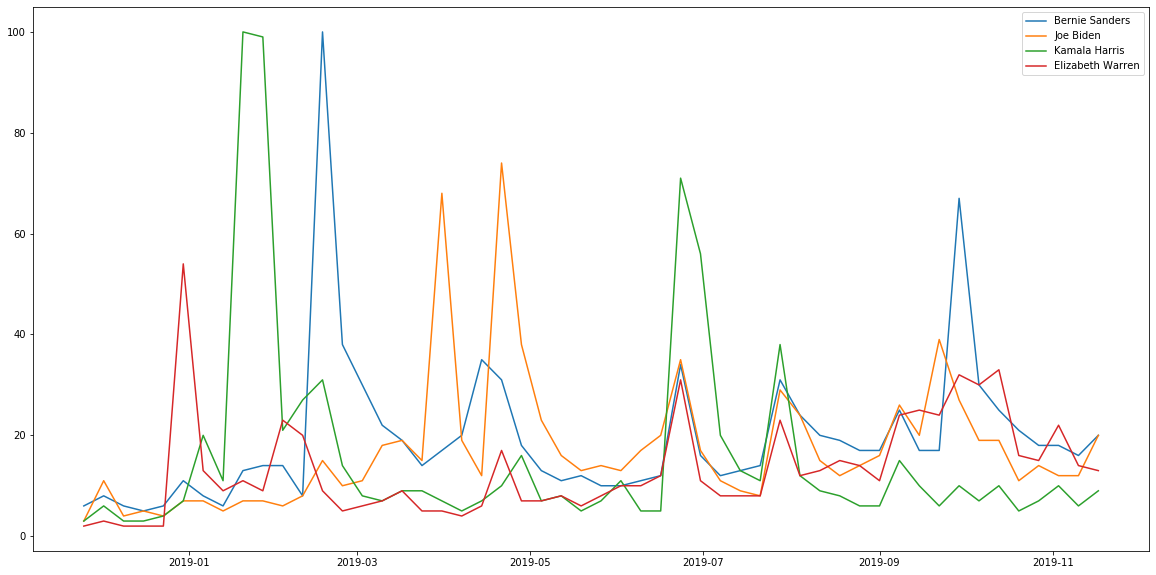

In [17]:
fig = plt.figure(figsize=(20,10)) # I like em big.. wha wha
ax = plt.subplot(111)
plt.plot(cand_test[test_list[0]])
plt.plot(cand_test[test_list[1]])
plt.plot(cand_test[test_list[2]])
plt.plot(cand_test[test_list[3]])
ax.legend(test_list[0:4])

##### Bernie wins! So he gets to be included every query of the API because we're dealing with relative data and it will only allow us a max of 5 key words.

### Pull data in three seperate queries of the API including Bernie Sanders in each.

In [0]:
# this one is for plotting
kw_list =  ["Bernie Sanders", "Joe Biden", "Cory Booker", 
             "Pete Buttigieg", "Tulsi Gabbard", "Kamala Harris", "Amy Klobuchar", 
             "Tom Steyer", "Elizabeth Warren", "Andrew Yang"]

# these are for qureying the API
kw_list_1 = ["Bernie Sanders", "Joe Biden", "Cory Booker", 
             "Pete Buttigieg", "Tulsi Gabbard"]

kw_list_2 = ["Bernie Sanders", "Kamala Harris", "Amy Klobuchar", 
             "Tom Steyer", "Elizabeth Warren"]
             
kw_list_3 = ["Bernie Sanders","Andrew Yang"]

### Save each query as its own variable

In [19]:
pytrends.build_payload(kw_list_1, cat=0, timeframe='2018-11-23 2019-11-23', geo='', gprop='')
cand1 = pytrends.interest_over_time()
cand1.head()

,Bernie Sanders,Joe Biden,Cory Booker,Pete Buttigieg,Tulsi Gabbard,isPartial
date,,,,,,
2018-11-25,6,3,1,0,1,False
2018-12-02,8,11,1,0,1,False
2018-12-09,6,4,1,0,1,False
2018-12-16,5,5,1,0,1,False
2018-12-23,6,4,1,0,1,False


In [20]:
pytrends.build_payload(kw_list_2, cat=0, timeframe='2018-11-23 2019-11-23', geo='', gprop='')
cand2 = pytrends.interest_over_time()
cand2.head()

,Bernie Sanders,Kamala Harris,Amy Klobuchar,Tom Steyer,Elizabeth Warren,isPartial
date,,,,,,
2018-11-25,6,3,1,1,2,False
2018-12-02,8,6,1,0,3,False
2018-12-09,6,3,1,0,2,False
2018-12-16,5,3,1,0,2,False
2018-12-23,6,4,1,0,2,False


In [21]:
pytrends.build_payload(kw_list_3, cat=0, timeframe='2018-11-23 2019-11-23', geo='', gprop='')
cand3 = pytrends.interest_over_time()
cand3.head()

,Bernie Sanders,Andrew Yang,isPartial
date,,,
2018-11-25,6,0,False
2018-12-02,8,0,False
2018-12-09,6,0,False
2018-12-16,5,0,False
2018-12-23,6,0,False


### PLOT ALL DEMOCRATIC CANDIDATES!!!!!!! 
(The hard way, before everything is combined cause I got excited)


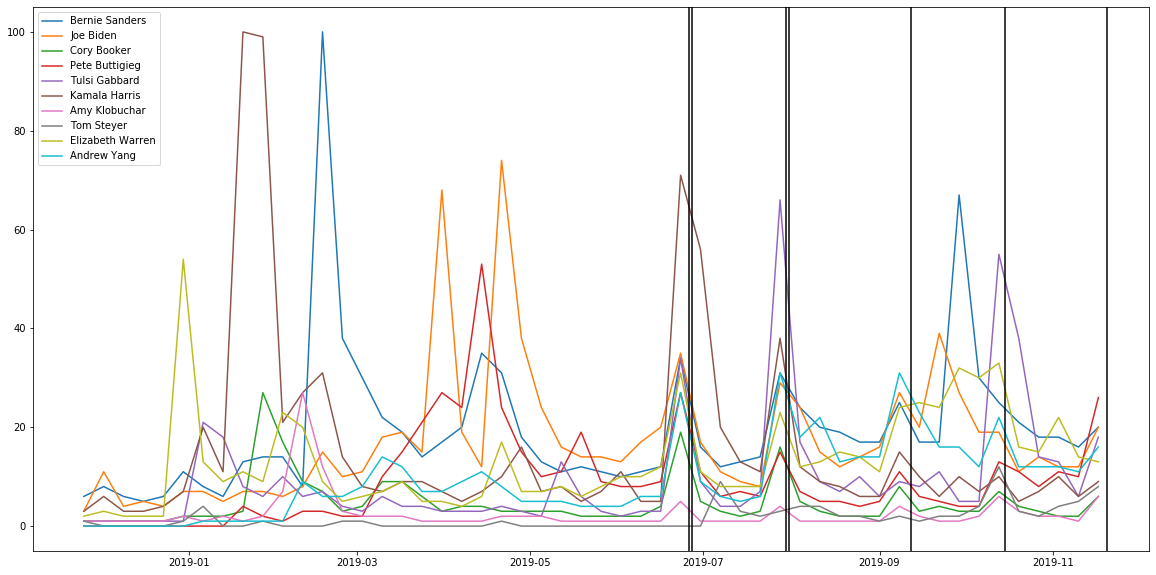

In [22]:
debate_dates = [pd.Timestamp('2019-06-26'), pd.Timestamp('2019-06-27'), pd.Timestamp('2019-07-30'), pd.Timestamp('2019-07-31'), pd.Timestamp('2019-09-12'), pd.Timestamp('2019-10-15'), pd.Timestamp('2019-11-20')]

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.plot(cand1.iloc[:,0])
plt.plot(cand1.iloc[:,1])
plt.plot(cand1.iloc[:,2])
plt.plot(cand1.iloc[:,3])
plt.plot(cand1.iloc[:,4])
plt.plot(cand2.iloc[:,1])
plt.plot(cand2.iloc[:,2])
plt.plot(cand2.iloc[:,3])
plt.plot(cand2.iloc[:,4])
plt.plot(cand3.iloc[:,1])
ax.legend(kw_list[0:10])
for item in debate_dates:
  ax.axvline(x=item, color='black')


<a name='concatpy'></a>



---




[Back to Navigation](#nav)

# Concatinating Google Data Together

In [23]:
# using .iloc so we dont concat Bernie three times
full_google = pd.concat([cand1.iloc[:,0:5], cand2.iloc[:,1:5], cand3.iloc[:,1]], axis=1)

# reset index so we can use dates easier
full_google.reset_index(inplace=True)

# full_google['date'] = full_google.reset_index(inplace=True)
full_google.head()


,date,Bernie Sanders,Joe Biden,Cory Booker,Pete Buttigieg,Tulsi Gabbard,Kamala Harris,Amy Klobuchar,Tom Steyer,Elizabeth Warren,Andrew Yang
0,2018-11-25,6,3,1,0,1,3,1,1,2,0
1,2018-12-02,8,11,1,0,1,6,1,0,3,0
2,2018-12-09,6,4,1,0,1,3,1,0,2,0
3,2018-12-16,5,5,1,0,1,3,1,0,2,0
4,2018-12-23,6,4,1,0,1,4,1,0,2,0


# **MERGING DATA:**

<a name='google_social'></a>



---




[Back to Navigation](#nav)

# Combining Social Studio and Google Data
Using social studio data as a baseline and left joining google data. Google data is weekly so the null values were filled using linear interpolation.

### Sort social studio data

In [24]:
full_social = full_social.sort_values(['date'])
full_social.head()

,segments__series,datetime,date,segments__segmentId,segments__type,segments__count,candidate
0,1,2018-11-23T03:00:00-04:00,2018-11-23,1,Blogs,30,booker
7,1,2018-11-23T03:00:00-04:00,2018-11-23,30,Reviews,0,gabbard
6,1,2018-11-23T03:00:00-04:00,2018-11-23,2,Videos,0,gabbard
5,1,2018-11-23T03:00:00-04:00,2018-11-23,14,Buy/Sell,0,gabbard
4,1,2018-11-23T03:00:00-04:00,2018-11-23,13,Aggregator,12,gabbard


### Subset social data based on type of social media (segments__type), in this case twitter, and candidate which is Bernie Sanders. Also subset google trends data to only include Bernie Sanders.

In [25]:
social_type = 'Twitter'
candidate = 'bernie'

subset_social = full_social.loc[(full_social['segments__type'] == social_type) & (full_social['candidate'] == candidate)]
subset_social.head()

subset_google = full_google.iloc[:,0:2]   ## this needs to be changed in a loop, right now == bernie
subset_google.head()

,segments__series,datetime,date,segments__segmentId,segments__type,segments__count,candidate
11,1,2018-11-23T03:00:00-04:00,2018-11-23,8,Twitter,19045,bernie
24,1,2018-11-24T03:00:00-04:00,2018-11-24,8,Twitter,23399,bernie
37,1,2018-11-25T03:00:00-04:00,2018-11-25,8,Twitter,30193,bernie
50,1,2018-11-26T03:00:00-04:00,2018-11-26,8,Twitter,34033,bernie
63,1,2018-11-27T03:00:00-04:00,2018-11-27,8,Twitter,93463,bernie


,date,Bernie Sanders
0,2018-11-25,6
1,2018-12-02,8
2,2018-12-09,6
3,2018-12-16,5
4,2018-12-23,6


### Merge data using left join 

In [26]:
social_google = pd.merge(subset_social, subset_google, how='left', on='date')
social_google.head()

,segments__series,datetime,date,segments__segmentId,segments__type,segments__count,candidate,Bernie Sanders
0,1,2018-11-23T03:00:00-04:00,2018-11-23,8,Twitter,19045,bernie,NaN
1,1,2018-11-24T03:00:00-04:00,2018-11-24,8,Twitter,23399,bernie,NaN
2,1,2018-11-25T03:00:00-04:00,2018-11-25,8,Twitter,30193,bernie,6.0
3,1,2018-11-26T03:00:00-04:00,2018-11-26,8,Twitter,34033,bernie,NaN
4,1,2018-11-27T03:00:00-04:00,2018-11-27,8,Twitter,93463,bernie,NaN


### Perform linear interpolation to fill null values

In [27]:
social_google['Bernie Sanders'] = social_google['Bernie Sanders'].interpolate(method='linear') # also needs a change if looping
social_google.head(10)

,segments__series,datetime,date,segments__segmentId,segments__type,segments__count,candidate,Bernie Sanders
0,1,2018-11-23T03:00:00-04:00,2018-11-23,8,Twitter,19045,bernie,NaN
1,1,2018-11-24T03:00:00-04:00,2018-11-24,8,Twitter,23399,bernie,NaN
2,1,2018-11-25T03:00:00-04:00,2018-11-25,8,Twitter,30193,bernie,6.000000
3,1,2018-11-26T03:00:00-04:00,2018-11-26,8,Twitter,34033,bernie,6.285714
4,1,2018-11-27T03:00:00-04:00,2018-11-27,8,Twitter,93463,bernie,6.571429
5,1,2018-11-28T03:00:00-04:00,2018-11-28,8,Twitter,61044,bernie,6.857143
6,1,2018-11-29T03:00:00-04:00,2018-11-29,8,Twitter,27071,bernie,7.142857
7,1,2018-11-30T03:00:00-04:00,2018-11-30,8,Twitter,22136,bernie,7.428571
8,1,2018-12-01T03:00:00-04:00,2018-12-01,8,Twitter,27639,bernie,7.714286
9,1,2018-12-02T03:00:00-04:00,2018-12-02,8,Twitter,41679,bernie,8.000000


<a name='add_poll'></a>



---




[Back to Navigation](#nav)

# Merging Poll Data with Social Studio and Google Trends Data

### Subset poll data on Bernie Sanders

In [28]:
sub_gbpolls = gbpolls.loc[gbpolls['answer'] == 'Sanders']   # for loop issue
sub_gbpolls.head()

,end_date,answer,pct
15,2019-01-13,Sanders,23.000000
34,2019-01-14,Sanders,15.000000
47,2019-01-16,Sanders,17.000000
71,2019-01-20,Sanders,17.666667
87,2019-01-21,Sanders,5.400000


### Merge the polls with google and social data and perform linear interpolation

In [0]:
full_data = pd.merge(social_google, sub_gbpolls, how='left', left_on='date', right_on='end_date')
full_data['pct'] = full_data['pct'].interpolate(method='linear')

# this lets you see very clearly when each dataset begins recording
# full_data.head(15) # long output

### Double check null value percentages

In [30]:
# the only true null values are at the beginning when our date ranges differ 
full_data.isnull().sum(axis=0) / full_data.shape[0]

segments__series       0.000000
datetime               0.000000
date                   0.000000
segments__segmentId    0.000000
segments__type         0.000000
segments__count        0.000000
candidate              0.000000
Bernie Sanders         0.005495
end_date               0.332418
answer                 0.332418
pct                    0.013736
dtype: float64

### Remove na's from joining on data that doesn't all start at the same time.

In [31]:
# drops na based on percent column *assumes pct column is earliest date range which could not be true*
full_data = full_data.dropna(axis=0, subset=['pct'])

#full_data.drop(['end_date', 'answer'], axis=1) #can drop these if we want, keeping for now (these null values remain because of linear interpolation)
full_data.head()

,segments__series,datetime,date,segments__segmentId,segments__type,segments__count,candidate,Bernie Sanders,end_date,answer,pct
5,1,2018-11-28T03:00:00-04:00,2018-11-28,8,Twitter,61044,bernie,6.857143,2018-11-28,Sanders,18.000000
6,1,2018-11-29T03:00:00-04:00,2018-11-29,8,Twitter,27071,bernie,7.142857,NaT,NaN,17.878788
7,1,2018-11-30T03:00:00-04:00,2018-11-30,8,Twitter,22136,bernie,7.428571,NaT,NaN,17.757576
8,1,2018-12-01T03:00:00-04:00,2018-12-01,8,Twitter,27639,bernie,7.714286,NaT,NaN,17.636364
9,1,2018-12-02T03:00:00-04:00,2018-12-02,8,Twitter,41679,bernie,8.000000,NaT,NaN,17.515152


# **LINEAR MODELS:**

<a name='inspect'></a>



---




[Back to Navigation](#nav)

# Inspecting and Preparing Data

### Subset columns

In [32]:
interested = ['segments__count', 'Bernie Sanders', 'pct']

model_data = full_data[interested]
model_data.head()

,segments__count,Bernie Sanders,pct
5,61044,6.857143,18.000000
6,27071,7.142857,17.878788
7,22136,7.428571,17.757576
8,27639,7.714286,17.636364
9,41679,8.000000,17.515152


### Scatter Plots

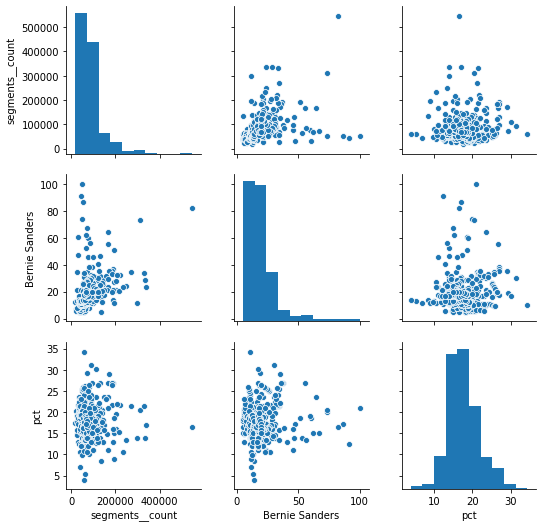

In [33]:
sns.pairplot(model_data)

### Creating percent change 

In [0]:
full_data['pct_change'] = full_data['pct'].pct_change()

### Manually lagging the poll percentages

In [35]:
full_data['pct_lag1'] = full_data['pct'].shift(1)
full_data.head()

,segments__series,datetime,date,segments__segmentId,segments__type,segments__count,candidate,Bernie Sanders,end_date,answer,pct,pct_change,pct_lag1
5,1,2018-11-28T03:00:00-04:00,2018-11-28,8,Twitter,61044,bernie,6.857143,2018-11-28,Sanders,18.000000,NaN,NaN
6,1,2018-11-29T03:00:00-04:00,2018-11-29,8,Twitter,27071,bernie,7.142857,NaT,NaN,17.878788,-0.006734,18.000000
7,1,2018-11-30T03:00:00-04:00,2018-11-30,8,Twitter,22136,bernie,7.428571,NaT,NaN,17.757576,-0.006780,17.878788
8,1,2018-12-01T03:00:00-04:00,2018-12-01,8,Twitter,27639,bernie,7.714286,NaT,NaN,17.636364,-0.006826,17.757576
9,1,2018-12-02T03:00:00-04:00,2018-12-02,8,Twitter,41679,bernie,8.000000,NaT,NaN,17.515152,-0.006873,17.636364


### Lagging pct change

In [0]:
full_data['pct_change_lag1'] = full_data['pct_change'].shift(1)


<a name='model_both'></a>



---




[Back to Navigation](#nav)

# Base Model With Social Studio and Twitter Data
The variable 'segments_count' is google trends data and the variable 'Bernie Sanders' is twitter data obtained through social studio. These both, in addition to the poll data, are in regards to Bernie Sanders alone.

### Linear Model with poll percent as is ('pct')
This would be promising if it weren't for severe autocorrelation in the poll data

In [0]:
from sklearn import metrics
from statsmodels.stats.stattools import durbin_watson

In [38]:
interested = ['segments__count', 'Bernie Sanders', 'pct']

model_data = full_data[interested]

X = model_data[['segments__count', 'Bernie Sanders']]
y = model_data['pct']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

summ = model.summary()
summ


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    pct   R-squared (uncentered):                   0.737
Model:                            OLS   Adj. R-squared (uncentered):              0.736
Method:                 Least Squares   F-statistic:                              501.4
Date:                Thu, 12 Dec 2019   Prob (F-statistic):                   2.10e-104
Time:                        04:29:58   Log-Likelihood:                         -1311.2
No. Observations:                 359   AIC:                                      2626.
Df Residuals:                     357   BIC:                                      2634.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
segments__count  8.156e-05   8.29e-06      9.835      0.000    6.53e-05    9.79e-05
Bernie Sanders      0.3380      0.035      9.535      0.000       0.268       0.408
==============================================================================
Omnibus:                      148.810   Durbin-Watson:                   0.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              961.710
Skew:                          -1.606   Prob(JB):                    1.47e-209
Kurtosis:                      10.347   Cond. No.                     7.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Mean Absolute Error

In [39]:
print(metrics.mean_absolute_error(predictions, model_data['pct']), '\n', durbin_watson(model.resid))

7.290030084359807 
 0.3936681186377751


### Linear model using poll percentage lagged one day
Again severe autocorrelation changes these findings

In [40]:
interested = ['segments__count', 'Bernie Sanders', 'pct_lag1']

model_data = full_data[interested]
model_data = model_data.dropna(axis=0, subset=['pct_lag1']) # drop the one na introduced by lagging

X = model_data[['segments__count', 'Bernie Sanders']]
y = model_data['pct_lag1']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

summ = model.summary()
summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               pct_lag1   R-squared (uncentered):                   0.736
Model:                            OLS   Adj. R-squared (uncentered):              0.735
Method:                 Least Squares   F-statistic:                              497.5
Date:                Thu, 12 Dec 2019   Prob (F-statistic):                   7.99e-104
Time:                        04:29:58   Log-Likelihood:                         -1307.6
No. Observations:                 358   AIC:                                      2619.
Df Residuals:                     356   BIC:                                      2627.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
segments__count  8.112e-05    8.3e-06      9.774      0.000    6.48e-05    9.74e-05
Bernie Sanders      0.3376      0.035      9.519      0.000       0.268       0.407
==============================================================================
Omnibus:                      171.074   Durbin-Watson:                   0.405
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1518.161
Skew:                          -1.788   Prob(JB):                         0.00
Kurtosis:                      12.434   Cond. No.                     7.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a name='percent_change'></a>



---




[Back to Navigation](#nav)

# Linear Model Predicting % Change in Poll Numbers 
Dealing with autocorrelation.

In [0]:
from statsmodels.tsa.stattools import adfuller

In [42]:
interested = ['segments__count', 'Bernie Sanders', 'pct_change']

model_data = full_data[interested]
model_data = model_data.dropna(axis=0, subset=['pct_change']) # drop the one na introduced by pct_change

X = model_data[['segments__count', 'Bernie Sanders']]
y = model_data['pct_change']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

summ = model.summary()
summ
adfuller(model_data['pct_change'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             pct_change   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              2.411
Date:                Thu, 12 Dec 2019   Prob (F-statistic):                      0.0912
Time:                        04:29:58   Log-Likelihood:                         -37.975
No. Observations:                 358   AIC:                                      79.95
Df Residuals:                     356   BIC:                                      87.71
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
segments__count  2.568e-07   2.39e-07      1.073      0.284   -2.14e-07    7.27e-07
Bernie Sanders      0.0002      0.001      0.243      0.808      -0.002       0.002
==============================================================================
Omnibus:                      203.622   Durbin-Watson:                   2.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2057.460
Skew:                           2.194   Prob(JB):                         0.00
Kurtosis:                      13.894   Cond. No.                     7.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(-18.683587962294514,
 2.0412360291476665e-30,
 1,
 356,
 {'1%': -3.448853029339765,
  '10%': -2.571113512498422,
  '5%': -2.869693115704379},
 48.026316604059616)

Mean Aboslute Error

In [43]:
metrics.mean_absolute_error(predictions, model_data['pct_change'])

0.16816925790298698

### Using percent change lagged by one day
No real difference between model above

In [44]:
interested = ['segments__count', 'Bernie Sanders', 'pct_change_lag1']

model_data = full_data[interested]
model_data = model_data.dropna(axis=0, subset=['pct_change_lag1']) # drop the one na introduced by pct_change

X = model_data[['segments__count', 'Bernie Sanders']]
y = model_data['pct_change_lag1']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

summ = model.summary()
summ
metrics.mean_absolute_error(predictions, model_data['pct_change_lag1'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        pct_change_lag1   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              1.905
Date:                Thu, 12 Dec 2019   Prob (F-statistic):                       0.150
Time:                        04:29:58   Log-Likelihood:                         -38.864
No. Observations:                 357   AIC:                                      81.73
Df Residuals:                     355   BIC:                                      89.48
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
segments__count  4.626e-08    2.4e-07      0.193      0.847   -4.26e-07    5.18e-07
Bernie Sanders      0.0010      0.001      0.975      0.330      -0.001       0.003
==============================================================================
Omnibus:                      203.889   Durbin-Watson:                   2.536
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2077.875
Skew:                           2.202   Prob(JB):                         0.00
Kurtosis:                      13.968   Cond. No.                     7.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.16744884060842477

<a name='debate_days'></a>



---




[Back to Navigation](#nav)

# Linear Model Removing Debate Days Predicting % Change
Again no real change compared to above

In [45]:
debate_dates = [pd.Timestamp('2019-06-26'), pd.Timestamp('2019-06-27'), pd.Timestamp('2019-07-30'), pd.Timestamp('2019-07-31'), pd.Timestamp('2019-09-12'), pd.Timestamp('2019-10-15'), pd.Timestamp('2019-11-20')]

y_of_interest = 'pct_change'

# remove debate days, "~" is a not operator in this context
no_debate_data = full_data.loc[~full_data['date'].isin(debate_dates)]

no_debate_data = no_debate_data.dropna(axis=0, subset=[y_of_interest])

X = no_debate_data[['segments__count', 'Bernie Sanders']]
y = no_debate_data[y_of_interest]


model = sm.OLS(y, X).fit()
predictions = model.predict(X)

summ = model.summary()
summ
metrics.mean_absolute_error(predictions, no_debate_data[y_of_interest])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             pct_change   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              2.546
Date:                Thu, 12 Dec 2019   Prob (F-statistic):                      0.0799
Time:                        04:29:58   Log-Likelihood:                         -35.856
No. Observations:                 351   AIC:                                      75.71
Df Residuals:                     349   BIC:                                      83.43
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
segments__count  3.169e-07   2.59e-07      1.221      0.223   -1.93e-07    8.27e-07
Bernie Sanders   7.748e-05      0.001      0.073      0.941      -0.002       0.002
==============================================================================
Omnibus:                      201.852   Durbin-Watson:                   2.572
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2112.242
Skew:                           2.205   Prob(JB):                         0.00
Kurtosis:                      14.179   Cond. No.                     7.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.16715944807156416

# **AUTOREGRESSIVE MODELS:**

<a name='auto'></a>



---




[Back to Navigation](#nav)

# Checking for Autocorrelation and Stationality Among Dependant Variable

### Stationality using augmented dickey fuller test

In [46]:
adfuller(full_data['pct'])

(-4.027838180182409,
 0.0012715561324597483,
 6,
 352,
 {'1%': -3.4490648539347544,
  '10%': -2.5711631253228306,
  '5%': -2.8697861692116478},
 1836.3052153916447)

### Plotting Bernie Sanders poll percentage

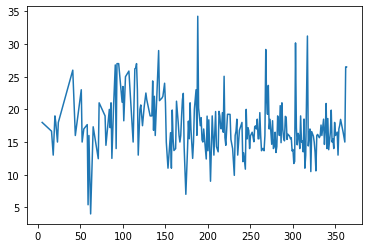

In [47]:
plt.plot(full_data['pct'])

### Plotting poll % change for Bernie Sanders

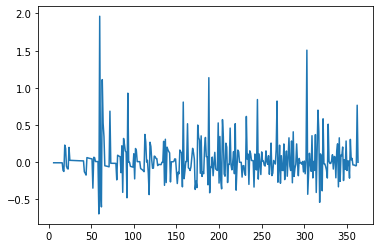

In [48]:
plt.plot(full_data['pct_change'])

### Checking autocorrelation and partial autocorrelation plots

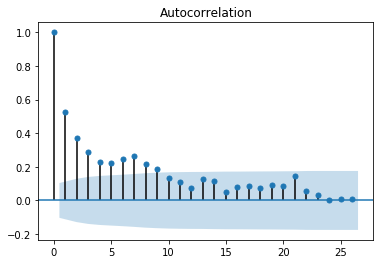

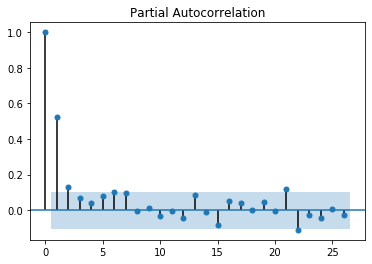

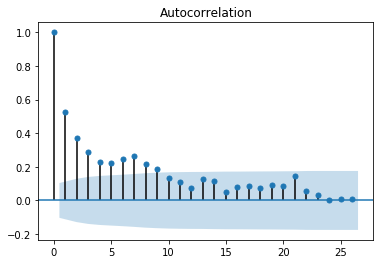

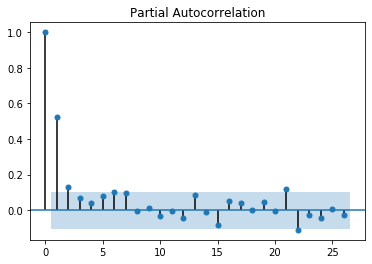

In [49]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(full_data['pct'])
plot_pacf(full_data['pct'])

<a name='prophet'></a>


---




[Back to Navigation](#nav)

# Prophet Models

Initial pass that doesn't fit well because data has not been aggregated

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 3.0128380631955562


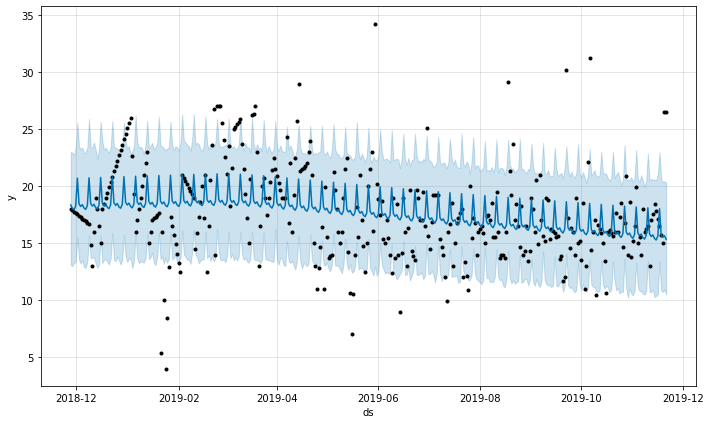

In [50]:
from fbprophet import Prophet

# subset data and rename columns
interested = ['date', 'pct']
model_data = full_data[interested]

model_data.columns = ['ds', 'y']

# THIS IS MY INITIAL PASS THAT DIDNT FIT WELL  
# create and fit model
m = Prophet()
m.fit(model_data)

# create a datafreame with the same dates that we currently have and then predict for those days
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig1 = m.plot(forecast)

# merge the forcasted dataframe with our original containing actual poll numbers
merged_data = pd.merge(model_data, forecast, on='ds')

# create new column with absolute value of residuals, then calculate mean
merged_data['resid_abs'] = abs(merged_data['yhat'] - model_data['y'])
print('\n', merged_data['resid_abs'].mean())

### Prophet model resampling by week (Best Prophet Model)
Although profit does a good job at picking changepoints we had to set the changepoint_prior_scale=1 to make sure the model fit the data well. This is done with caution as it could lead to overfitting.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


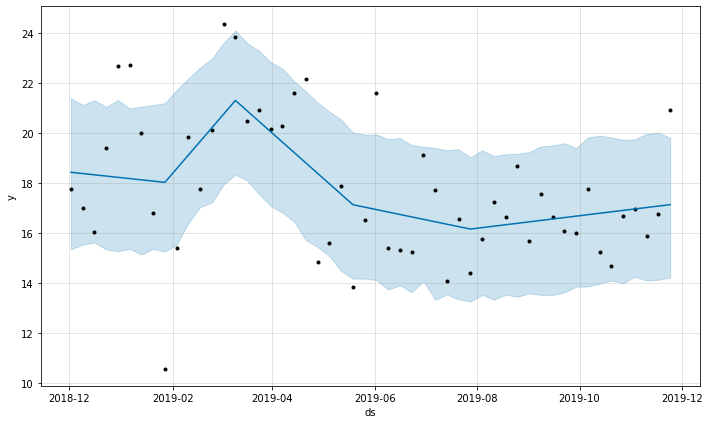

In [51]:
# convert column to datetime and save as index
model_data['ds'] = pd.to_datetime(model_data['ds'])
model_data.index = model_data['ds']

# resample by weeks starting on sunday calculating the mean
resampled_data = model_data.resample('W').mean()

# convert index back to column to be fed through prophet
resampled_data.reset_index(level=0, inplace=True)

# create and fit profit
m = Prophet(changepoint_prior_scale=1)
m.fit(resampled_data)

# create a datafreame with the same dates that we currently have and then predict for those days
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# plot forcast
fig1 = m.plot(forecast)

Prophet Mean Absolute Error

In [52]:
abs_diff = abs(resampled_data.iloc[:,1] - forecast.iloc[:,1])
abs_diff.mean()

1.7128022813547312

### Prophet model using % change (Curiousity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


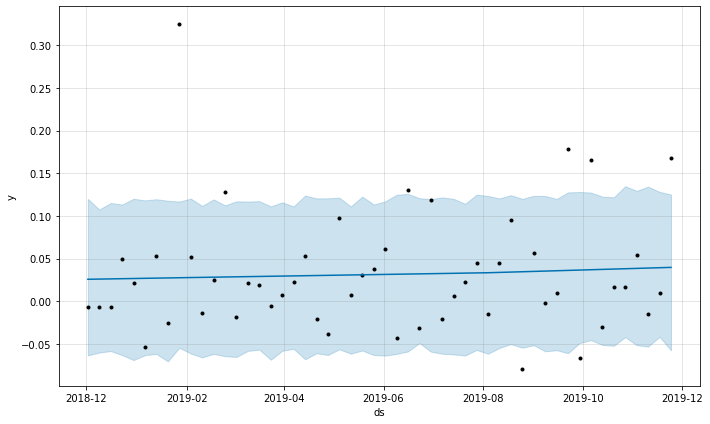

In [53]:
# subset and rename columns
interested = ['date', 'pct_change']
model_data = full_data[interested]

model_data.columns = ['ds', 'y']

# convert column to datetime and save as index
model_data['ds'] = pd.to_datetime(model_data['ds'])
model_data.index = model_data['ds']

# resample by weeks starting on sunday calculating the mean
resampled_data = model_data.resample('W').mean()

# convert index back to column to be fed through prophet
resampled_data.reset_index(level=0, inplace=True)

# create and fit profit
m = Prophet(changepoint_prior_scale=1)
m.fit(resampled_data)

# create a datafreame with the same dates that we currently have and then predict for those days
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# plot forcast
fig1 = m.plot(forecast)

Mean Absolute Error

In [54]:
abs_diff = abs(resampled_data.iloc[:,1] - forecast.iloc[:,1])
abs_diff.mean()

0.05006621102485113

<a name='arima'></a>


---




[Back to Navigation](#nav)

# ARIMA Models

### Checking for stationality among possible exogs

(-7.099633082377915,
 4.2007447894040017e-10,
 2,
 356,
 {'1%': -3.448853029339765,
  '10%': -2.571113512498422,
  '5%': -2.869693115704379},
 8287.834514722137)

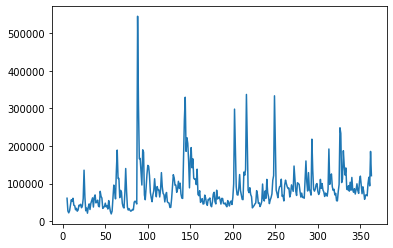

In [55]:
# google trends data
plt.plot(full_data['segments__count'])
adfuller(full_data['segments__count'])

(-3.896870269942848,
 0.0020580013107614073,
 15,
 343,
 {'1%': -3.449559661646851,
  '10%': -2.5712790073013796,
  '5%': -2.8700035112469626},
 1091.258809152127)

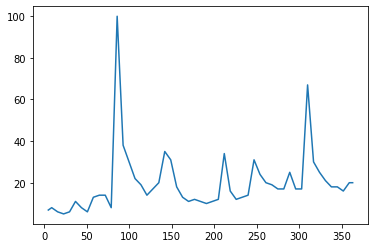

In [56]:
# Twitter data
plt.plot(full_data['Bernie Sanders'])
adfuller(full_data['Bernie Sanders'])

### Base ARIMA Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/t

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.pct   No. Observations:                  358
Model:                 ARIMA(2, 1, 5)   Log Likelihood                -953.109
Method:                       css-mle   S.D. of innovations              3.461
Date:                Thu, 12 Dec 2019   AIC                           1924.217
Time:                        04:30:14   BIC                           1959.142
Sample:                    11-29-2018   HQIC                          1938.107
                         - 11-21-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0046      0.033      0.139      0.890      -0.060       0.069
ar.L1.D.pct     0.8806      0.064     13.841      0.000       0.756       1.005
ar.L2.D.pct    -0.9271      0.061    -15.108      0.000      -1.047      -0.807
ma.L1.D.pct    -1.4302      0.083    -17.274      0.000      -1.592      -1.268
ma.L2.D.pct     1.2746      0.130      9.827      0.000       1.020       1.529
ma.L3.D.pct    -0.4841      0.124     -3.920      0.000      -0.726      -0.242
ma.L4.D.pct    -0.0890      0.098     -0.909      0.364      -0.281       0.103
ma.L5.D.pct    -0.0873      0.061     -1.433      0.153      -0.207       0.032
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4750           -0.9236j            1.0386           -0.1744
AR.2            0.4750           +0.9236j            1.0386            0.1744
MA.1            0.4499           -0.9163j            1.0207           -0.1774
MA.2            0.4499           +0.9163j            1.0207            0.1774
MA.3            1.1342           -0.0000j            1.1342           -0.0000
MA.4           -1.5267           -2.7135j            3.1135           -0.3316
MA.5           -1.5267           +2.7135j            3.1135            0.3316
-----------------------------------------------------------------------------
"""

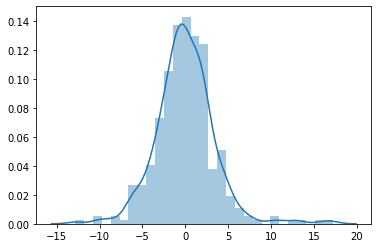

In [57]:
from statsmodels.tsa.arima_model import ARIMA

interested = ['date', 'pct']
model_data = full_data[interested]


# convert column to datetime and save as index
model_data['date'] = pd.to_datetime(model_data['date'])
model_data.set_index('date', inplace=True)


model = ARIMA(model_data, order=(2,1,5)) # O.G. = 3, 1, 10
model_fit = model.fit(disp=0)

model_fit.summary()
residuals = pd.DataFrame(model_fit.resid)
sns.distplot(residuals, hist=True, kde=True)


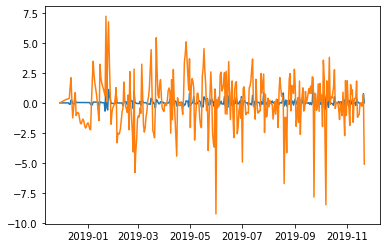

In [58]:
actual = full_data[['date', 'pct_change']]
actual = actual.dropna(axis=0)
actual.set_index('date', inplace=True)
fitted = pd.DataFrame(model_fit.fittedvalues)

plt.plot(actual.iloc[:,0])
plt.plot(fitted.iloc[:,0])

 Mean Absolute Error

In [59]:
abs(actual.iloc[:,0] - fitted.iloc[:,0]).mean()

1.3871682853519076

### ARIMA model adding in google data as an exog parameter
Some strange output here

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check ml

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.pct   No. Observations:                  358
Model:                 ARIMA(2, 1, 5)   Log Likelihood                -954.263
Method:                       css-mle   S.D. of innovations              3.474
Date:                Thu, 12 Dec 2019   AIC                           1928.526
Time:                        04:30:16   BIC                           1967.331
Sample:                    11-29-2018   HQIC                          1943.959
                         - 11-21-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0184      0.104     -0.176      0.860      -0.223       0.186
segments__count   2.86e-07   1.16e-06      0.246      0.806   -1.99e-06    2.56e-06
ar.L1.D.pct        -0.0387      1.610     -0.024      0.981      -3.195       3.118
ar.L2.D.pct        -0.1392        nan        nan        nan         nan         nan
ma.L1.D.pct        -0.4929      1.639     -0.301      0.764      -3.706       2.720
ma.L2.D.pct        -0.0160        nan        nan        nan         nan         nan
ma.L3.D.pct        -0.1526        nan        nan        nan         nan         nan
ma.L4.D.pct        -0.1019      0.118     -0.865      0.388      -0.333       0.129
ma.L5.D.pct        -0.0273      0.252     -0.108      0.914      -0.521       0.467
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1389           -2.6763j            2.6799           -0.2582
AR.2           -0.1389           +2.6763j            2.6799            0.2582
MA.1            1.1227           -0.0000j            1.1227           -0.0000
MA.2            0.2112           -1.7930j            1.8054           -0.2313
MA.3            0.2112           +1.7930j            1.8054            0.2313
MA.4           -2.6381           -1.7445j            3.1627           -0.4070
MA.5           -2.6381           +1.7445j            3.1627            0.4070
-----------------------------------------------------------------------------
"""

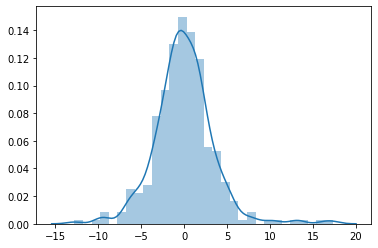

In [60]:
interested = ['date', 'pct', 'segments__count']
model_data = full_data[interested]


# convert column to datetime and save as index
model_data['date'] = pd.to_datetime(model_data['date'])
model_data.set_index('date', inplace=True)

exog1 = model_data['segments__count']
new_data = model_data['pct']

model = ARIMA(new_data, order=(2,1,5), exog = exog1) # O.G. = 3, 1, 10
model_fit = model.fit(disp=0)

model_fit.summary()
residuals = pd.DataFrame(model_fit.resid)
sns.distplot(residuals, hist=True, kde=True)

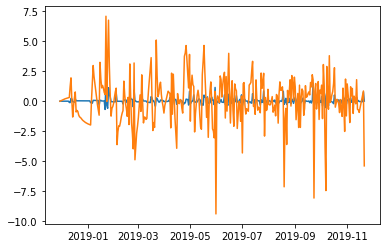

In [61]:
actual = full_data[['date', 'pct_change']]
actual = actual.dropna(axis=0)
actual.set_index('date', inplace=True)
fitted = pd.DataFrame(model_fit.fittedvalues)

plt.plot(actual.iloc[:,0])
plt.plot(fitted.iloc[:,0])

Mean Absolute Error

In [62]:
abs(actual.iloc[:,0] - fitted.iloc[:,0]).mean()

1.3008712344812092